# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Импорты

In [1]:
pip install -U scikit-learn -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install -U scikit-learn -q,
!pip install phik -q


Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: -,


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import (OneHotEncoder, 
                                     OrdinalEncoder, 
                                     StandardScaler, 
                                     MinMaxScaler, 
                                     RobustScaler,
                                     PolynomialFeatures)
from sklearn.linear_model import LinearRegression, Lasso, Ridge,LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC, SVR
from sklearn.metrics import mean_squared_error
import  numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import phik
#import my_function as fc
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import SelectKBest,f_classif, mutual_info_classif  

import warnings
from sklearn.dummy import DummyRegressor, DummyClassifier
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


plt.rcParams["figure.figsize"] = (7,7)

warnings.filterwarnings('ignore')
RANDOM_STATE = 42

### Функции

In [4]:
# поиск пропусков
def nan_search(datalist):
    for k, v in datalist.items():
        print(k,'\n')
        print(v.isna().sum())
        print('-'*50)

#поиск дубликатов
def dublic_search(datalist):
    for k, v in datalist.items():
        print(k,'\n')
        print(v.duplicated().sum())
        print('-'*50)
# функция кругового графика
def pie(df,title):
    #colors = sns.color_palette("light:#5A9")
    #df.plot(kind='pie',colors=colors,shadow=True,
                                      #title = title);
    #plt.legend()
    #plt.show()
    plot = df.plot.pie(startangle=0)
    plt.ylabel('')
    percents = df.to_numpy() * 100 / df.to_numpy().sum()
    plt.legend( bbox_to_anchor=(1.35,1.1), loc='upper right',
            labels=['%s, %1.1f %%' % (l, s) for l, s in zip(df.index,percents)])
    plt.show()

# функция для построения графиков разбиных на категориальные step =1, и количественные step=2
def analysis(df, step:int):
    if step==1:
        for i in df.select_dtypes(include='object').columns:
            print('-----',i,'-----')
            print(df[i].value_counts())
            print()
            
            pie(df[i].value_counts(), i);
    if step==2:
        for i in df.select_dtypes(exclude='object').columns:
            print('------',i,'---------')
            print(df[i].describe())
            print()
            boxhist(data=df, x=i, title=i);

# ящик с усами
def boxplot(data, x, title):
    sns.boxplot(data=data, x=x,palette="crest");
    plt.title(title)
    plt.show()

# функция для построения ящика с усами и хистограмы для просмотра распределения
def boxhist(data, x, title):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    sns.boxplot(ax=axes[0],data=data, x=x,palette="crest");
    axes[0].set_xlabel(title)
    axes[0].set_title(title)


    sns.histplot(ax=axes[1],data=data, x=x, kde=True, palette="crest");
    axes[1].set_title(title);
    axes[1].set_xlabel(title)
    axes[1].axvline(data[x].mean(), c='k', ls='-', lw=2.5)
    axes[1].axvline(data[x].median(), c='orange', ls='--', lw=2.5)
    plt.xlabel(title);
    plt.show()

def emissions(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = 1.5 * (q3 -q1)
    df.loc[df[column]>q3+iqr, column]=q3+iqr
    df.loc[df[column]<q1-iqr, column]=q1-iqr
    return df

### Загрузка и обработка данных

In [5]:
data = pd.read_csv('/datasets/autos.csv')

In [6]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Для предказания стоимости автомобиля не нужны данные с датами скачивания регистрации и последней активности.

In [8]:
# назад в будущее
# определим последниию дату скачивания анкеты из базы
# понадобится в будущем
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'])
data['DateCrawled'].max()

Timestamp('2016-04-07 14:36:58')

In [9]:
data["NumberOfPictures"].unique()

array([0])

In [10]:
# удалим столбцы с датами и индексом
data=data.drop(['DateCrawled','LastSeen','DateCreated','PostalCode','RegistrationMonth','NumberOfPictures'], axis=1)


In [11]:
# Изменение названий признаков
data = data.rename(columns={'VehicleType':'vehicle_type','RegistrationYear':'registration_year','FuelType':'fuel_type'})
data.columns=data.columns.str.lower()

In [12]:
data.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354369 non-null  int64 
 1   vehicle_type       316879 non-null  object
 2   registration_year  354369 non-null  int64 
 3   gearbox            334536 non-null  object
 4   power              354369 non-null  int64 
 5   model              334664 non-null  object
 6   kilometer          354369 non-null  int64 
 7   fuel_type          321474 non-null  object
 8   brand              354369 non-null  object
 9   repaired           283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


In [14]:
# Пропуски
datalist = {'data':data}
nan_search(datalist)

data 

price                    0
vehicle_type         37490
registration_year        0
gearbox              19833
power                    0
model                19705
kilometer                0
fuel_type            32895
brand                    0
repaired             71154
dtype: int64
--------------------------------------------------


Как видим присутствует очень много пропусков.Попытаемся это исправить.


In [15]:
data['vehicle_type'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [16]:
data['fuel_type'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [17]:
data['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [18]:
data['model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

In [19]:
data['repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

В столбце `vehicle_type` ,`fuel_type`, `model` присутствует категория `other`. Запишим все пропуски в other.
И так в признаке `repaired` и `gearbox` 3 значения. Так и оставим заменив попуски новой категорией `unknown`.

In [20]:
other_list =['vehicle_type' ,'fuel_type', 'model']
for i in other_list:
    data[i] =data[i].fillna('other')

In [21]:
data['gearbox']=data['gearbox'].fillna('unknown')
data['repaired']=data['repaired'].fillna('unknown')

In [22]:
data.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

In [23]:
# дубликаты
data.duplicated().sum()

45191

In [24]:
data=data.drop_duplicates()

- Загрузили данные.
- Привели названия столбцов к стандарту.
- Удалили ненужные признаки.
- Избавились от пропусков.
- Удалили дубликаты.

## Исследовательский анализ данных

----- vehicle_type -----
sedan          78179
small          67529
wagon          56364
other          37647
bus            25819
convertible    18192
coupe          14680
suv            10768
Name: vehicle_type, dtype: int64



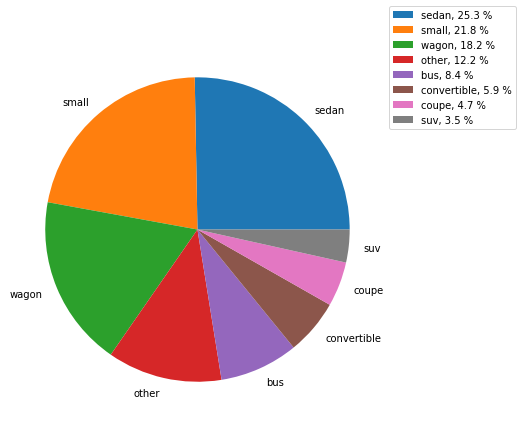

----- gearbox -----
manual     232688
auto        59333
unknown     17157
Name: gearbox, dtype: int64



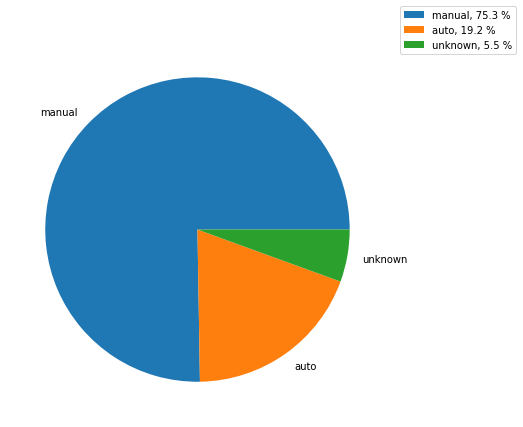

----- model -----
other                 41155
golf                  23636
3er                   16699
polo                  10494
corsa                  9738
                      ...  
kalina                    7
rangerover                4
serie_3                   4
serie_1                   2
range_rover_evoque        1
Name: model, Length: 250, dtype: int64



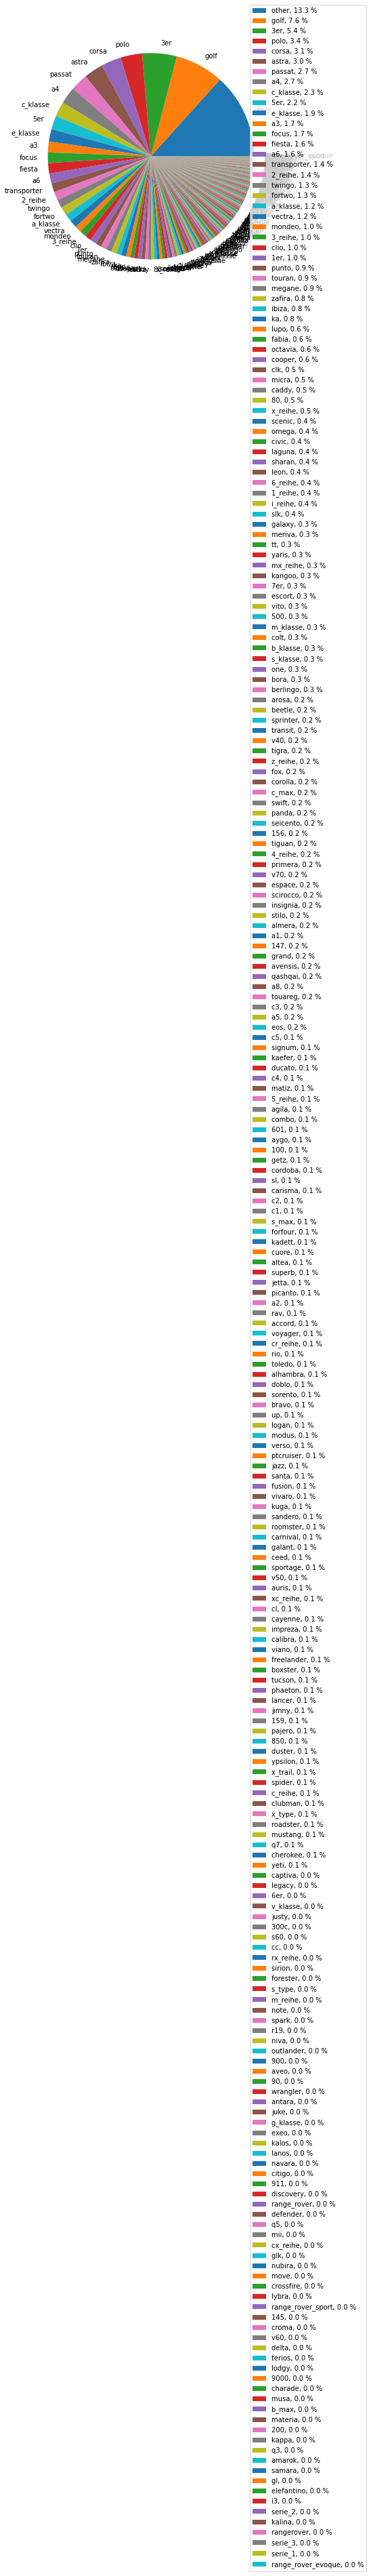

----- fuel_type -----
petrol      187776
gasoline     84772
other        30909
lpg           4887
cng            524
hybrid         222
electric        88
Name: fuel_type, dtype: int64



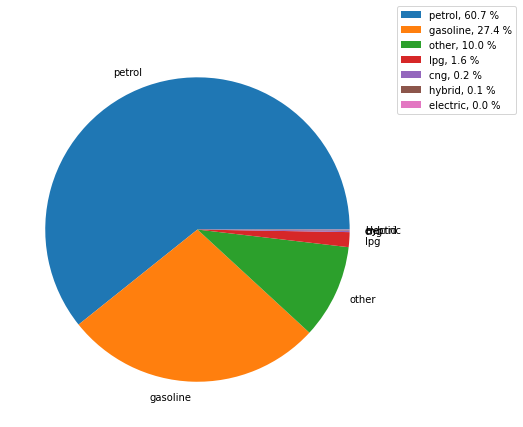

----- brand -----
volkswagen        63893
opel              33947
bmw               31707
mercedes_benz     28680
audi              25468
ford              22394
renault           15795
peugeot            9798
fiat               8670
seat               6187
mazda              5106
skoda              4965
smart              4823
citroen            4791
nissan             4482
toyota             4243
hyundai            3289
sonstige_autos     2919
volvo              2906
mini               2864
mitsubishi         2810
honda              2635
kia                2243
suzuki             2152
alfa_romeo         2141
chevrolet          1643
chrysler           1350
dacia               830
daihatsu            752
subaru              726
porsche             699
jeep                639
trabant             554
daewoo              508
land_rover          507
saab                484
jaguar              479
rover               446
lancia              443
lada                210
Name: brand, dtype: in

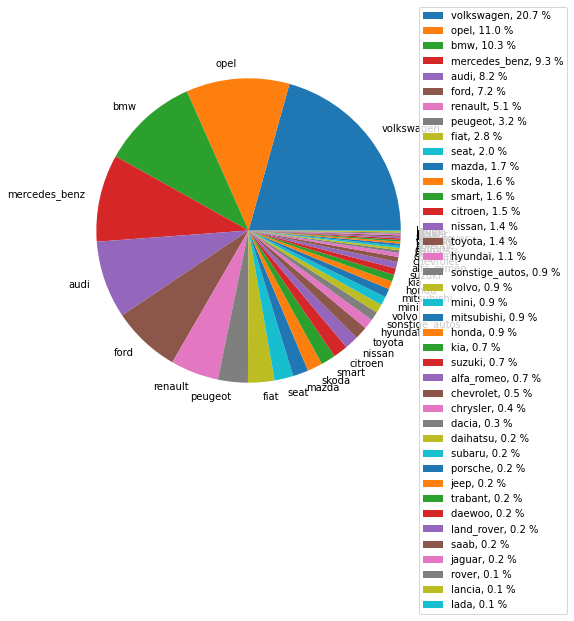

----- repaired -----
no         211255
unknown     64490
yes         33433
Name: repaired, dtype: int64



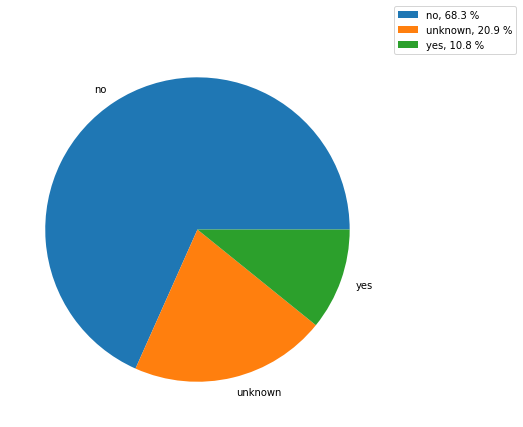

In [25]:
analysis(data, step=1)

------ price ---------
count    309178.000000
mean       4487.898495
std        4565.099808
min           0.000000
25%        1100.000000
50%        2800.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64



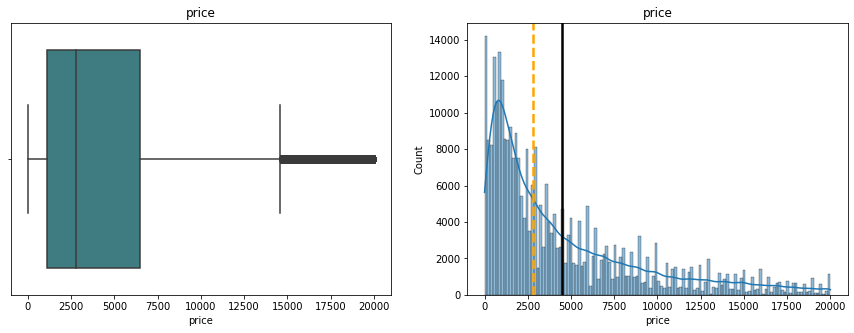

------ registration_year ---------
count    309178.000000
mean       2004.362875
std          92.563413
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64



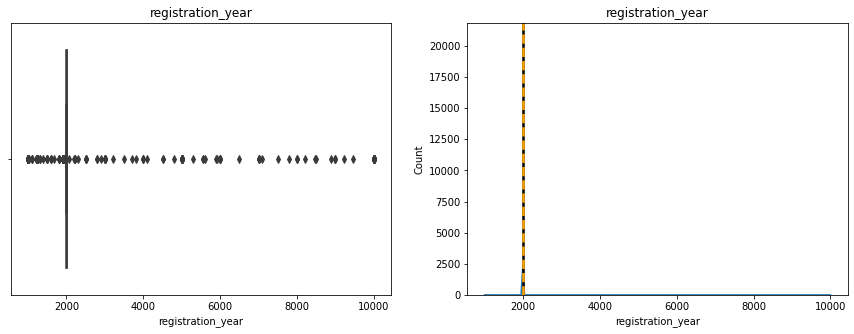

------ power ---------
count    309178.000000
mean        110.996976
std         201.009413
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64



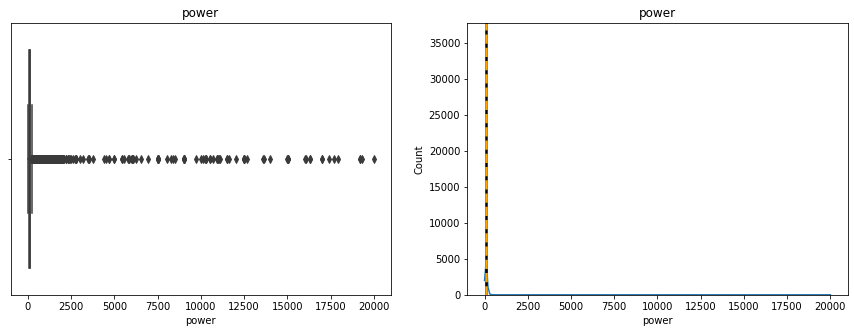

------ kilometer ---------
count    309178.000000
mean     127221.131516
std       38526.706414
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64



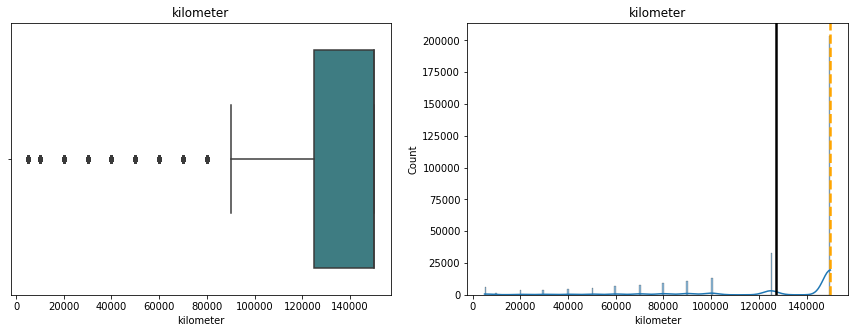

In [26]:
analysis(data, step=2)

Видим в данных выбросы и аномалии разберемся с этим

In [27]:
# price
# удалим все нулевые значения
data=data.query('price > 500')

In [28]:
#registration_year
# минимальный 83 а максимальный больше похож на случайное число
# минимальный год определим как 1940(подсмотрел мимальный год на изветсном сайте автопродаж)
# максимальный определим по последней дате скачивания из базы т.е. 2016г
# удалим все что ниже 1940 и выше 2016
data = data.query('1940<= registration_year <= 2016') 

In [29]:
# power
# удалим нулевые значения
print(data.loc[data['power']==0]['price'].count())
data=data.query('40 < power <=2000')

21983


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 237182 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              237182 non-null  int64 
 1   vehicle_type       237182 non-null  object
 2   registration_year  237182 non-null  int64 
 3   gearbox            237182 non-null  object
 4   power              237182 non-null  int64 
 5   model              237182 non-null  object
 6   kilometer          237182 non-null  int64 
 7   fuel_type          237182 non-null  object
 8   brand              237182 non-null  object
 9   repaired           237182 non-null  object
dtypes: int64(4), object(6)
memory usage: 19.9+ MB


In [31]:
# заменим выбросы на значения  ближайшего "уса"
numlist=['price', 'power']
for i in numlist:
    emissions(data,i)

### Корреляция

In [32]:
cf = data.phik_matrix(interval_cols=numlist) 

In [33]:
cf.style.background_gradient(cmap='Blues')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
price,1.000000,0.247763,0.663049,0.267048,0.499802,0.555680,0.320299,0.231232,0.342826,0.294812
vehicle_type,0.247763,1.000000,0.603460,0.255126,0.501871,0.909263,0.217950,0.369228,0.634515,0.206894
registration_year,0.663049,0.603460,1.000000,0.159583,0.273481,0.654350,0.641536,0.390389,0.359489,0.291078
gearbox,0.267048,0.255126,0.159583,1.000000,0.468026,0.626683,0.070883,0.175954,0.521940,0.236201
power,0.499802,0.501871,0.273481,0.468026,1.000000,0.803395,0.149915,0.244539,0.593007,0.069888
model,0.555680,0.909263,0.654350,0.626683,0.803395,1.000000,0.440767,0.521772,0.997659,0.192156
kilometer,0.320299,0.217950,0.641536,0.070883,0.149915,0.440767,1.000000,0.202285,0.266945,0.177314
fuel_type,0.231232,0.369228,0.390389,0.175954,0.244539,0.521772,0.202285,1.000000,0.273868,0.167795
brand,0.342826,0.634515,0.359489,0.521940,0.593007,0.997659,0.266945,0.273868,1.000000,0.095584
repaired,0.294812,0.206894,0.291078,0.236201,0.069888,0.192156,0.177314,0.167795,0.095584,1.000000


Наблюдаем мультиколлинеарность входного признака `model` сразу с двумя другими признаками `brand` и `vehicle_type`. Удалим его.

In [34]:
data = data.drop(['model'], axis=1)

Вывод:

- Провели анализ данных.
- Избавились от аномалий.
- Избавились от выбросов.
- Удалили признак `model` из-за мультиколлинеарности

## Подготовка данных

In [35]:
X= data.drop(['price'], axis=1)
y= data['price']
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state = RANDOM_STATE)

In [36]:
# подготовка столбцов
selector = SelectKBest(f_classif, k=9)
col_ohe = list(X_train.select_dtypes(include='object').columns)
col_num = list(X_train.select_dtypes(exclude='object').columns)


Создаем пайпланы.

In [37]:
#кодировщик OneHotEncoder
pipe_ohe = Pipeline([('ohe', OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1))])

In [38]:

preprocessor = ColumnTransformer(
    [
    ('ohe', pipe_ohe, col_ohe),
    ('num', StandardScaler(), col_num)
    ], 
    remainder='passthrough') 

In [39]:
X_train_final =pd.DataFrame(
    preprocessor.fit_transform(X_train),
    columns=preprocessor.get_feature_names_out() )
X_test_final =pd.DataFrame(
    preprocessor.transform(X_test),
    columns=preprocessor.get_feature_names_out())

Разделили данные на обучающею и тренировочную.

Создали пай планы.

Все готово для обучения моделей.


## Обучение моделей

### LGBMRegressor

In [40]:
pipe_lgbm = Pipeline(
    [('preprocessor', preprocessor),
    ('models', LGBMRegressor(seed=RANDOM_STATE))])

In [41]:
 param_grid = {
      'models__learning_rate': [0.1, 0.01],
      'models__n_estimators': [50, 100, 150],
      'models__max_depth': [4, 6, 10],
      'models__colsample_bytree': [0.7, 0.8, 0.9]
      }

In [42]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 177886 entries, 89672 to 170932
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   vehicle_type       177886 non-null  object 
 1   registration_year  177886 non-null  int64  
 2   gearbox            177886 non-null  object 
 3   power              177886 non-null  float64
 4   kilometer          177886 non-null  int64  
 5   fuel_type          177886 non-null  object 
 6   brand              177886 non-null  object 
 7   repaired           177886 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 12.2+ MB


In [44]:
model = RandomizedSearchCV(
    pipe_lgbm, 
    param_grid,
    cv=3, 
    n_jobs=-1, 
    scoring='neg_root_mean_squared_error',
    error_score='raise')
model.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('ohe',
                                                                                                OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                               unknown_value=-1))]),
                                                                               ['vehicle_type',
                                                                                'gearbox',
                                                                                'fuel_type',
                                                                                'brand',
                                                                                'repaired']),
                                                                              ('num',
                                                                               StandardScaler(),
                                                                               ['registration_year',
                                                                                'power',
                                                                                'kilometer'])])),
                                             ('models',
                                              LGBMRegressor(seed=42))]),
                   n_jobs=-1,
                   param_distributions={'models__colsample_bytree': [0.7, 0.8,
                                                                     0.9],
                                        'models__learning_rate': [0.1, 0.01],
                                        'models__max_depth': [4, 6, 10],
                                        'models__n_estimators': [50, 100, 150]},
                   scoring='neg_root_mean_squared_error')

In [45]:
%%time
model_lgbmr= model.best_estimator_
model_lgbmr.fit(X_train, y_train)

CPU times: user 2min 2s, sys: 380 ms, total: 2min 2s
Wall time: 2min 2s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['vehicle_type', 'gearbox',
                                                   'fuel_type', 'brand',
                                                   'repaired']),
                                                 ('num', StandardScaler(),
                                                  ['registration_year', 'power',
                                                   'kilometer'])])),
                ('models',
                 LGBMRegressor(colsample_bytree=0.7, max_depth=10,
                               n_estimators=150, seed=42))])

In [46]:
%%time
val_pred_lgbmr = model_lgbmr.predict(X_train)
print ('Метрика RMSE на тренировочной выборке:', round(mean_squared_error(y_train,val_pred_lgbmr, squared=False)))

Метрика RMSE на тренировочной выборке: 1595
CPU times: user 2.02 s, sys: 0 ns, total: 2.02 s
Wall time: 2.08 s


LGBMRegressor - Время обучения 2 минуты 2 секунды..
Время предсказания 2 секунды.

RMSE - 1595

### CatBoostRegressor

In [47]:

model_cat = CatBoostRegressor(loss_function='RMSE',silent=True, 
                              cat_features=col_ohe, random_seed=RANDOM_STATE)



In [48]:
param_cat = {
      'learning_rate': [0.3, 0.1, 0.01],
      'iterations': [50, 100, 150],
      'depth': [4, 6, 10]
      }

In [49]:
model = RandomizedSearchCV(
    model_cat, 
    param_cat,
    cv=3, 
    n_jobs=-1, 
    scoring='neg_root_mean_squared_error',
    error_score='raise')
model.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=<catboost.core.CatBoostRegressor object at 0x7efc7eb7a400>,
                   n_jobs=-1,
                   param_distributions={'depth': [4, 6, 10],
                                        'iterations': [50, 100, 150],
                                        'learning_rate': [0.3, 0.1, 0.01]},
                   scoring='neg_root_mean_squared_error')

In [50]:
%%time
model_cat= model.best_estimator_
model_cat.fit(X_train, y_train)

CPU times: user 9.22 s, sys: 78.5 ms, total: 9.3 s
Wall time: 10 s


In [51]:
%%time
val_pred_cat = model_cat.predict(X_train)
print ('Метрика RMSE на тренировочной выборке:',round( mean_squared_error(y_train,val_pred_cat, squared=False)))

Метрика RMSE на тренировочной выборке: 1504
CPU times: user 223 ms, sys: 2.33 ms, total: 225 ms
Wall time: 225 ms


Время обучения состовляет 10 секунд.
Время предсказания - 225 мс.
RMSE - 1504

### DecisionTreeRegressor

In [52]:
param_grid_dtc =[{
        'models__max_depth': range(3,10),
        'models__min_samples_leaf': range(1,4),
        'models__max_features': range(3,8),
        'models__min_samples_split': range(3,7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),RobustScaler(), 'passthrough']
}]

In [53]:
pipe_dtc = Pipeline(
    [('preprocessor', preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))])

In [54]:
random_tree = RandomizedSearchCV(
    pipe_dtc, 
    param_grid_dtc, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    error_score='raise',
    n_jobs=-1
)

random_tree.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('ohe',
                                                                                                OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                               unknown_value=-1))]),
                                                                               ['vehicle_type',
                                                                                'gearbox',
                                                                                'fuel_type',
                                                                                'brand',
                                                                                'repaired']),
                                                                              ('num',
                                                                               StandardScaler(),
                                                                               ['registration_year',
                                                                                'po...
                                             ('models',
                                              DecisionTreeRegressor(random_state=42))]),
                   n_jobs=-1,
                   param_distributions=[{'models__max_depth': range(3, 10),
                                         'models__max_features': range(3, 8),
                                         'models__min_samples_leaf': range(1, 4),
                                         'models__min_samples_split': range(3, 7),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   scoring='neg_root_mean_squared_error')

In [55]:
%%time
model_dtr = random_tree.best_estimator_
model_dtr.fit(X_train, y_train)

CPU times: user 348 ms, sys: 71 µs, total: 348 ms
Wall time: 351 ms


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['vehicle_type', 'gearbox',
                                                   'fuel_type', 'brand',
                                                   'repaired']),
                                                 ('num', StandardScaler(),
                                                  ['registration_year', 'power',
                                                   'kilometer'])])),
                ('models',
                 DecisionTreeRegressor(max_depth=9, max_features=6,
                                       min_samples_leaf=2, min_samples_split=4,
                                       random_state=42))])

In [56]:
%%time
val_pred_dtr = model_dtr.predict(X_train)
print ('Метрика RMSE на тренировочной выборке:',round( mean_squared_error(y_train,val_pred_dtr, squared=False)))

Метрика RMSE на тренировочной выборке: 1953
CPU times: user 175 ms, sys: 9 µs, total: 175 ms
Wall time: 178 ms


Время обучения- 351мс.
Время предсказания- 178 мс

RMSE - 1953

Провели обучение 3 моделей:

- CatBoostRegressor
- DecisionTreeRegressor
- LGBMRegressor
RMSE всех моделей на обучающей выборке менее 2500.


## Анализ моделей

Были обучены три модели, результаты

LGBMRegressor:
- Время обучения 40.2 секунд
- Время предсказания 2.28 секунды
- RMSE 1558

По скорости предсказания — это худшая модель, вторая по Времени обучения и метрике.

CatBoostRegressor:
- Время обучения 10 секунд
- Время предсказания 225 Миллисекунд
- RMSE 1504

CatBoost оказался худшей моделью по времени обучения, вторая по скорости предсказания и лучшая по метрике.

DecisionTreeRegressor:
- Время обучения 351 Миллисекунд
- Время предсказания 178 Миллисекунд
- RMSE 1953.

Лучшая по скоростям обучения и предсказания модель и худшая по метрике.

Из-за всего выше перечисленного мы остановимся на модели CatBoostRegressor. Модель показала лучшую метрику, так же скорость предсказания меньше секунды. Так же CatBoost не требует предварительной обработки категориальных данных. Т.е. данные перед обучением/предсказанием можно не кодировать.


In [57]:
# Проверка на адекватность
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)
dum= dummy_regr.predict(X_test)
print('RMSE =',round( mean_squared_error(y_test,dum, squared=False)))

RMSE = 4493


In [58]:
%%time
# предсказание модели на тренировочной выборке
val_pred_cat = model_cat.predict(X_test)
print ('Метрика RMSE на тренировочной выборке:',round( mean_squared_error(y_test,val_pred_cat, squared=False)))

Метрика RMSE на тренировочной выборке: 1590
CPU times: user 77.3 ms, sys: 18 µs, total: 77.3 ms
Wall time: 89 ms


На тестовой выборке модель CatBoostRegressor:
- RMSE 1590 что укладывается в условие "Значение метрики RMSE должно быть меньше 2500."
- время предсказания - 89 миллисекунд
- значение метрики модели DummyRegressor - 4493

## Вывод


Были загружены и исследованы данные сервиса по продаже автомобилей с пробегом «Не бит, не крашен».
- Удалены ненужные признаки.
- Обработаны аномальные значения, пропуски, дубликаты и выбросы.

Проведена подготовка к обучению:
- Данные разбиты на обучающие и тестовые выборки.
- созданы нужные пай планы.

Были обучены 3 модели
1. LGBMRegressor
- RMSE 1527.
2. CatBoostRegressor
- RMSE 1495.
3. DecisionTreeRegressor
- RMSE 1623.

После анализа моделей под критерии заказчика была выбрана модель CatBoostRegressor.
- Проверку на адекватность пройдена.
- У модели лучшая метрика RMSE.
- Скорость предсказания тестовых данных составляет 89 миллисекунды.
- RMSE тестовых данных составляет 1590.
